#Kindly consider following baseline implementation of Multilayer Perceptron

In [ ]:
!pip install d2l==1.0.3

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

## Declare Trainer Routine
- For now we will use in-built data loader
- fit function is yet to be explored

In [ ]:
class Trainer(d2l.HyperParameters):
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def prepare_batch(self, batch):
      if self.gpus:
        batch = [a.to(self.gpus[0]) for a in batch]
      return batch

    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

    def param_dropout(param, drop_prob):
      if drop_prob == 0:
          return param
      mask = (torch.rand(param.shape) > drop_prob).float()
      return param * mask

## Declare Model

In [ ]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

    def relu(self,X):
        a = torch.zeros_like(X)
        return torch.max(X, a)

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H = self.relu(torch.matmul(X, self.W1) + self.b1)
        return torch.matmul(H, self.W2) + self.b2

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

    def configure_optimizers(self):
      return torch.optim.SGD(self.parameters(), lr=self.lr)


## Get Dataset

In [ ]:
data = d2l.FashionMNIST(batch_size=256)

100%|██████████| 26421880/26421880 [00:00<00:00, 116502158.73it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 9026240.07it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 63437628.63it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4008219.23it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



##  Check GPU

In [ ]:
def cpu():
    """Get the CPU device."""
    return torch.device('cpu')

def gpu(i=0):
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

cpu(), gpu(), gpu(1)

(device(type='cpu'),
 device(type='cuda', index=0),
 device(type='cuda', index=1))

In [ ]:
def num_gpus():
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

num_gpus()

1

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

In [ ]:
x = torch.tensor([1, 2, 3], device=try_gpu())
x.device

device(type='cuda', index=0)

In [ ]:
x

tensor([1, 2, 3], device='cuda:0')

## Initialize model

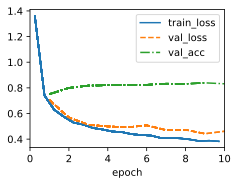

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
model = model.to(device=try_gpu())

trainer = d2l.Trainer(max_epochs=10,num_gpus=1)
trainer.fit(model, data)

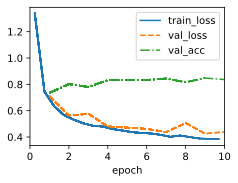

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

#Questions
## Provide empirical evidence using implementation for following questions.

##Q1) Try your model using GPU for training and try number of epochs as [10, 20, 30, 40]
##Kindly report your observations. [1 Marks]

In [ ]:
def select_device(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def available_gpus():
    return [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]

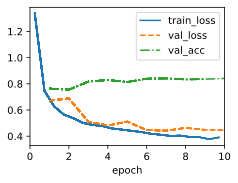

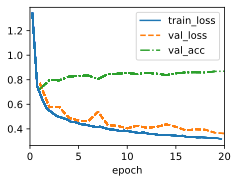

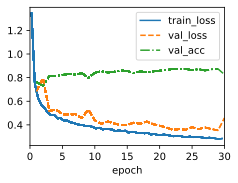

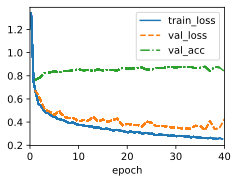

In [ ]:
epoch_trials = [10, 20, 30, 40]
dataset = d2l.FashionMNIST(batch_size=256)

for epoch_count in epoch_trials:
    model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
    model = model.to(device=try_gpu())
    trainer = Trainer(max_epochs=epoch_count, num_gpus=1)
    print(f"Training for {epoch_count} epochs:")
    trainer.fit(model, data)

## Q2) Kindly add $l_2$ regualization to model, by updating loss function carefully.
## [3 Marks]

In [ ]:
class MLPModelWithL2(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, lambd=0.01, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.num_inputs = num_inputs
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))
        self.lambd = lambd

    def relu(self, X):
        return torch.max(X, torch.zeros_like(X))

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H = self.relu(torch.matmul(X, self.W1) + self.b1)
        return torch.matmul(H, self.W2) + self.b2

    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        ce_loss = F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')

        l2_penalty = 0
        for param in self.parameters():
            if param.requires_grad:
                l2_penalty += torch.sum(param ** 2)
        return ce_loss + self.lambd * l2_penalty

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

def select_device(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def available_gpus():
    return [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]

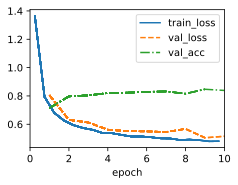

In [ ]:
model = MLPModelWithL2(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1, lambd=0.001, sigma=0.01)
model = model.to(device=select_device())
trainer = Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, dataset)

## Q3) After adding regularizer kindly add dropout on parameters and not on output. your dropout should be a function which takes parameter matrix and percentage drop as input argument and output the dropped paramater matrix. [4 Marks]

In [ ]:
class MLPModelWithL2AndDropout(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, lambd=0.01, sigma=0.01, dropout_prob=0.5):
        super().__init__()
        self.save_hyperparameters()
        self.num_inputs = num_inputs
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))
        self.lambd = lambd
        self.dropout_prob = dropout_prob

    def relu(self, X):
        return torch.max(X, torch.zeros_like(X))

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        W1_dropped = param_dropout(self.W1, self.dropout_prob)
        W2_dropped = param_dropout(self.W2, self.dropout_prob)
        H = self.relu(torch.matmul(X, W1_dropped) + self.b1)
        return torch.matmul(H, W2_dropped) + self.b2

    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        ce_loss = F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')

        l2_penalty = 0
        for param in self.parameters():
            l2_penalty += torch.sum(param ** 2)

        return ce_loss + self.lambd * l2_penalty

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def param_dropout(param, drop_prob):
      if drop_prob == 0:
          return param
      mask = (torch.rand(param.shape) > drop_prob).float()
      return param * mask


In [ ]:
def param_dropout(param, drop_prob):
    if drop_prob == 0:
        return param
    mask = (torch.rand(param.shape, device=param.device) > drop_prob).float()
    return param * mask

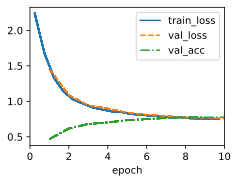

In [ ]:
model = MLPModelWithL2AndDropout(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1, lambd=0.001, dropout_prob=0.5, sigma=0.01)
model = model.to(device=select_device())
data = d2l.FashionMNIST(batch_size=256)
trainer = Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

##Q4) Justify that this dropout can achieve more general result than dropout layer mentioned in reference book. [3 Marks]

## **Answer 4**
By applying dropout to the weight instead of the activations, the model is being able to generalize better. Now the model is not only changing the activations but it is changing the weights inside the activations which lets the model learn more generalized features and hence the model does not rely on specific connections
The main advantage over the dropout layer in the ref book is that:
1. It forces the model to adapt to various subsets of weights which leads to better performance and,
2. lets to model generalize by not giving too much emphasis to any specific subset of paramters

The dropout on parameter approach is more direct approach than traditional dropout approach since it directly affects the weights in the model and not just the connections.